# Evaluate Experiments

---

## Imports

In [1]:
import itertools
import json
import os
import pickle
import random
import re
import string

from pathlib import Path

import contractions
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords

from tqdm import tqdm

In [2]:
STOP_WORDS = set(stopwords.words("english"))

---

## List Experiments 

In [3]:
parent_folder = Path(f"../experiments/")
all_subfolder = os.listdir(parent_folder)

experiments = list()
for sub in all_subfolder:
    folder = parent_folder / sub
    try:
        with open(folder / "grid_params.json", "r") as f:
            grid = json.load(f)
    except FileNotFoundError:
        continue
    with open(folder / "metrics_validation.json", "r") as f:
        val_metrics = json.load(f)
    if os.path.exists(folder / "history.pkl"):
        with open(folder / "history.pkl", "rb") as f:
            history = pickle.load(f)
            actual_epochs = len(history["loss"])
    else:
        actual_epochs = 10
    grid["code"] = sub
    grid["f1_macro"] = val_metrics["f1_macro"]
    grid["actual_epoch"] = actual_epochs
    experiments.append(grid)
experiments = (
    pd.DataFrame(experiments)
    .assign(trainable=lambda f: f["trainable"].fillna("all"))
    .assign(dropout=lambda f: f["dropout"].fillna(0.3))
    .assign(label_smoothing=lambda f: f["label_smoothing"].fillna(0))
    .assign(scheduler=lambda f: f["scheduler"].fillna(0.2))
    .sort_values(by=["f1_macro"], ascending=False)
)

---

## Configs

In [4]:
EXPERIMENT = "20230803T072725"

---

## Load Experiment 

In [5]:
folder = Path(f"../experiments/{EXPERIMENT}")

with open(folder / "grid_params.json", "r") as f:
    grid = json.load(f)
    
    
if os.path.exists(folder / "history.pkl"):
    with open(folder / "history.pkl", "rb") as f:
        history = pickle.load(f)
elif os.path.exists(folder / "history_0.pkl"):
    history_files = [f for f in os.listdir(folder) if "history_" in f]
    history = dict()
    for file in history_files:
        with open(folder / file, "rb") as f:
            history[int(file.split("_")[-1].replace(".pkl", ""))] = pickle.load(f)
else:
    history = None
    
    
with open(folder / "metrics_validation.json", "r") as f:
    val_metrics = json.load(f)
    
    
with open(folder / "confusion_matrix_validation.pkl", "rb") as f:
    val_confusion_matrix = pickle.load(f)

if os.path.exists(folder / "original_predictions.pkl"):
    with open(folder / "original_predictions.pkl", "rb") as f:
        original_predictions = pickle.load(f)
    
data_for_exp = pd.read_pickle(folder / "data_for_exp.pkl")
predictions = pd.read_pickle(folder / "prediction_validation.pkl")
misclassification = pd.read_pickle(folder / "misclassification_validation.pkl")
correct = data_for_exp.loc[lambda f: f["set"] == "validation"].loc[lambda f: ~f["code"].isin(misclassification.code)]

## Experiment Analysis

In [6]:
grid

{'model': 'bert-base-uncased',
 'trainable': 'all',
 'head': 'none',
 'scheduler': '0.2',
 'dropout': 0.3,
 'label_smoothing': 0,
 'epochs': 10,
 'batch_size': 16,
 'learning_rate': 5e-05,
 'emoji_tagging': True,
 'clean_data': False,
 'balancing': 'none',
 'augment': False,
 'minority_shuffling': {'grief_sadness': ['grief', 'sadness'],
  'pride_admiration': ['pride', 'admiration'],
  'relief_approval': ['relief', 'approval'],
  'anger_annoyance': ['anger', 'annoyance'],
  'nervousness_fear': ['nervousness', 'fear'],
  'joy': ['joy'],
  'realization': ['realization'],
  'surprise': ['surprise'],
  'neutral': ['neutral'],
  'optimism': ['optimism'],
  'desire': ['desire'],
  'love': ['love'],
  'disapproval': ['disapproval'],
  'amusement': ['amusement'],
  'caring': ['caring'],
  'excitement': ['excitement'],
  'curiosity': ['curiosity'],
  'embarrassment': ['embarrassment'],
  'disgust': ['disgust'],
  'gratitude': ['gratitude'],
  'confusion': ['confusion'],
  'disappointment': ['dis

### Metrics Summary 

In [7]:
print(
    f"Macro F1-Score: {val_metrics['f1_macro']:.3f}", 
    f"Micro F1-Score: {val_metrics['f1_micro']:.3f}", 
    f"ROC-AUC: {val_metrics['roc_auc']:.3f}", 
    sep="\n"
)

Macro F1-Score: 0.534
Micro F1-Score: 0.603
ROC-AUC: 0.926


### History 

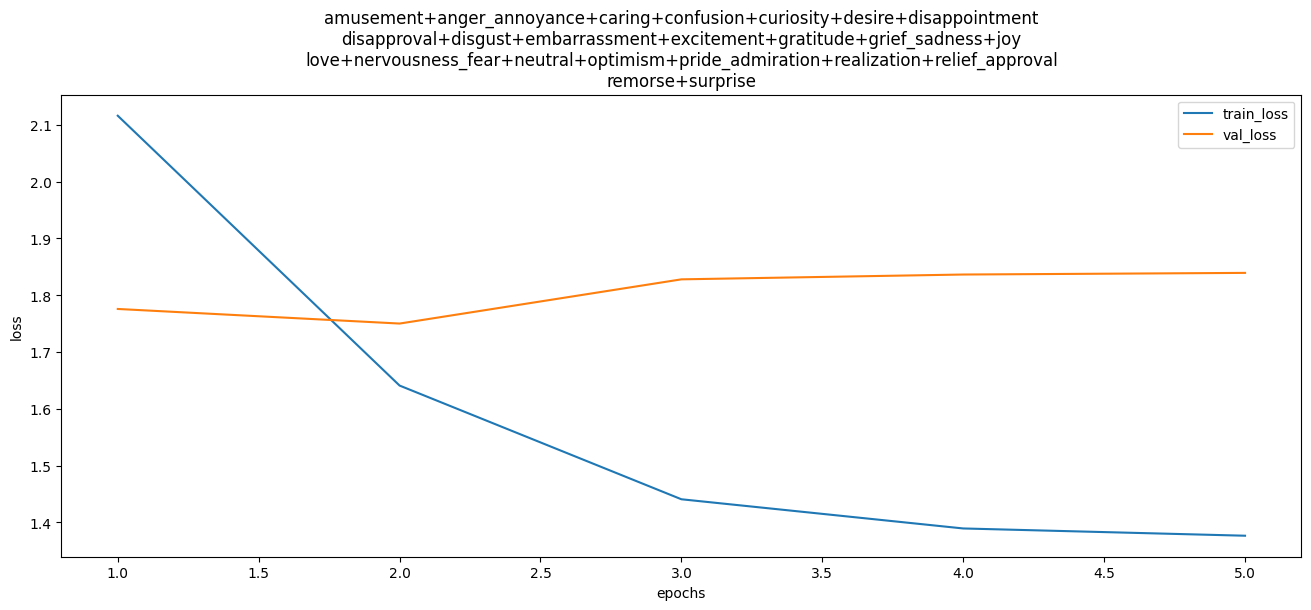

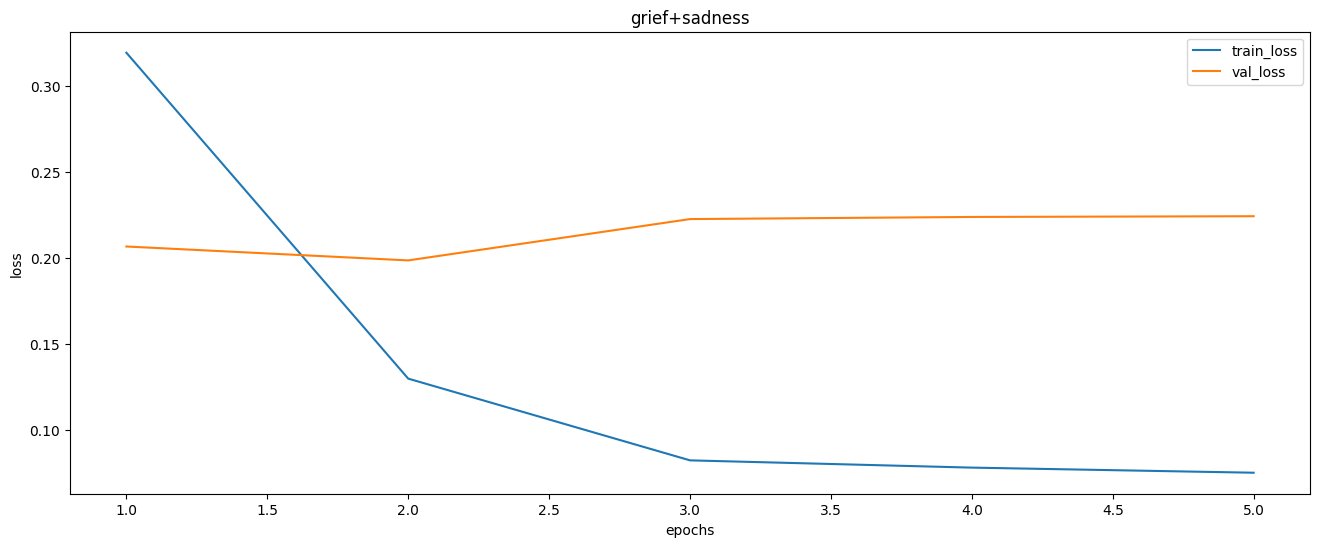

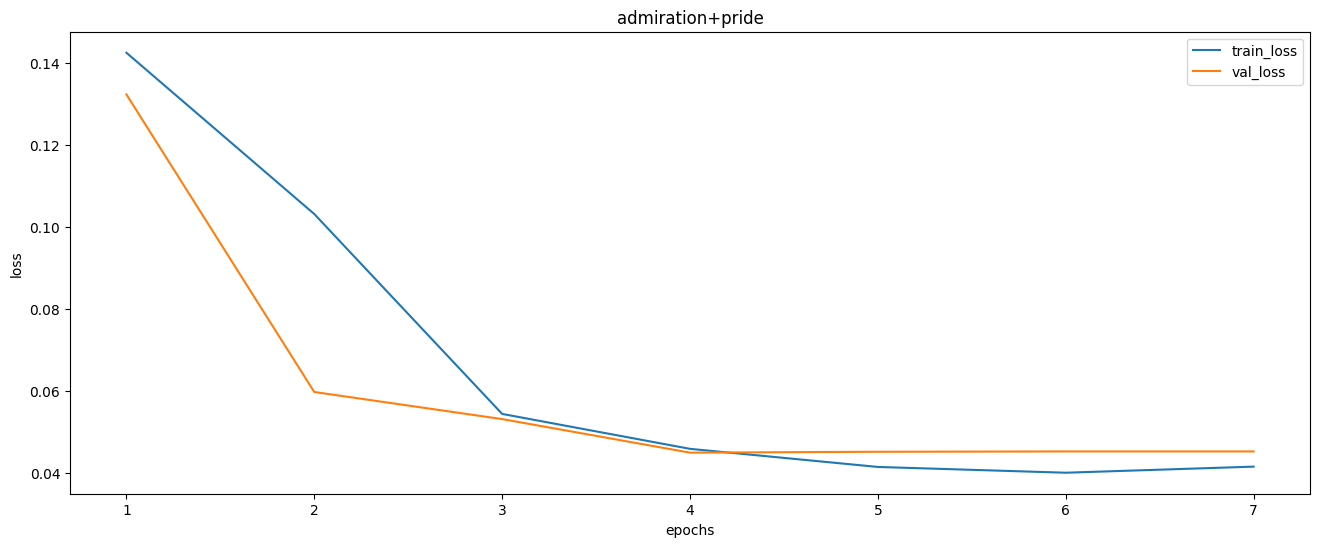

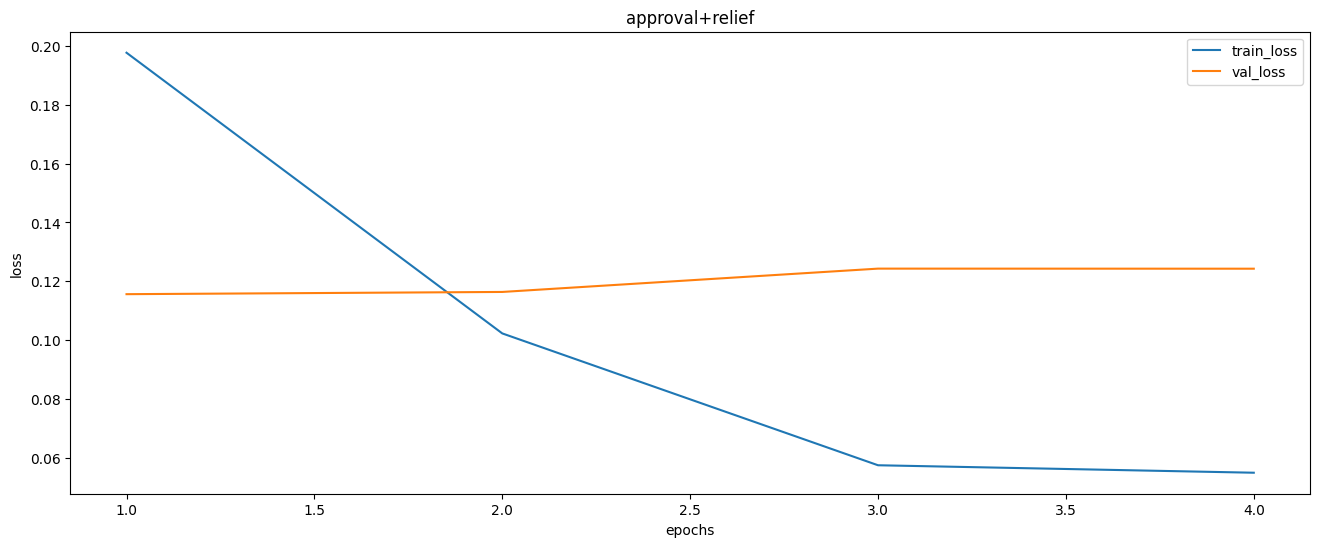

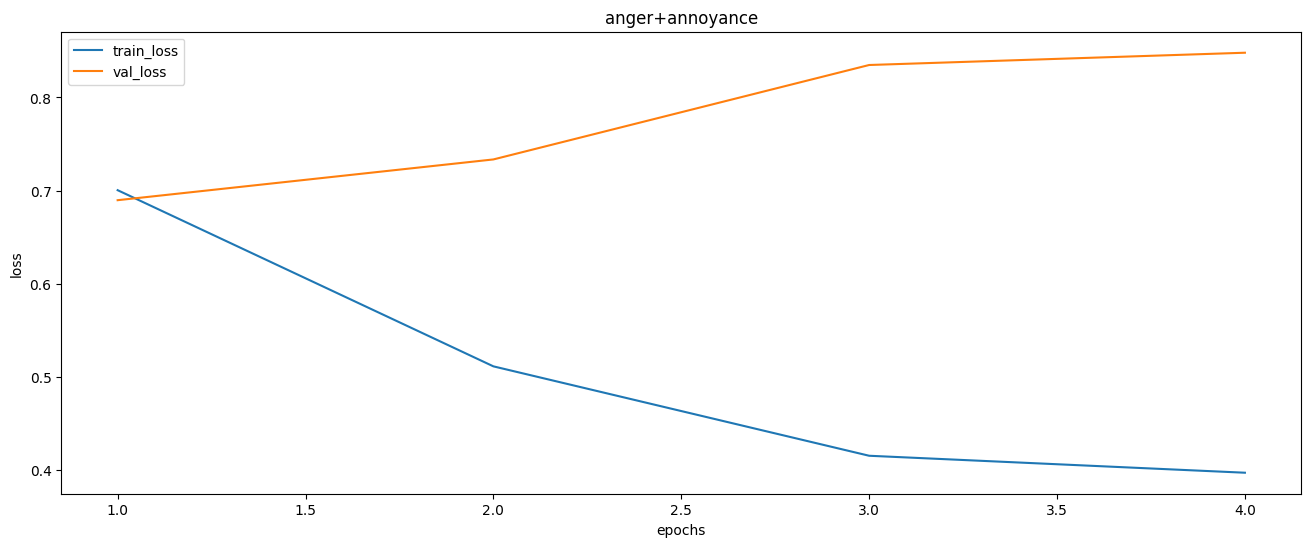

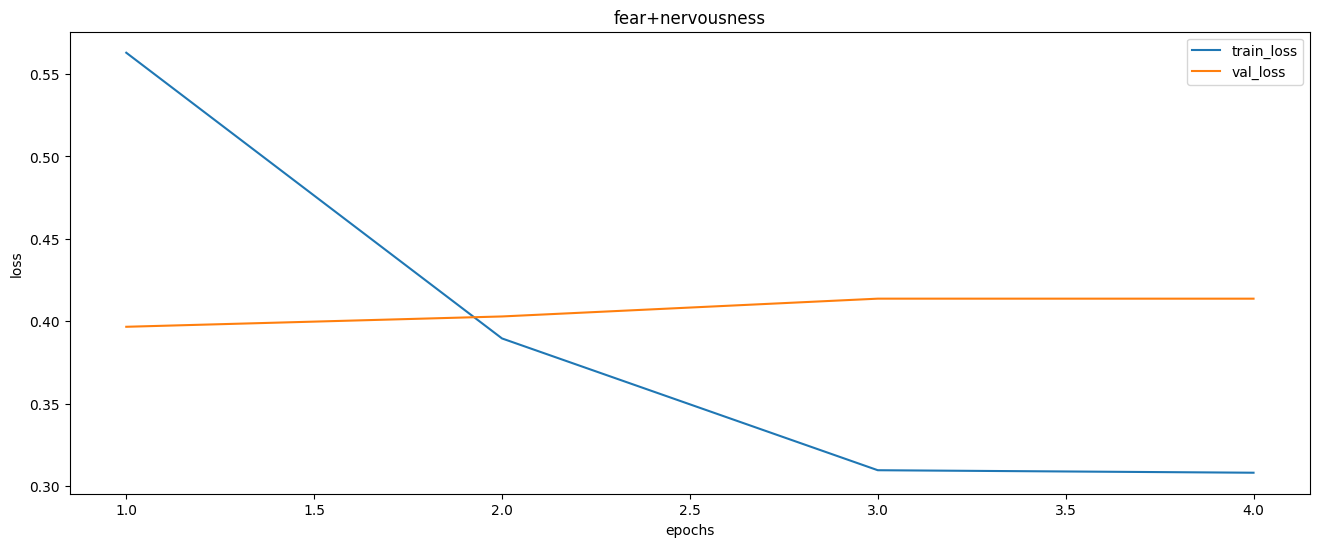

In [8]:
if history is not None:
    if 0 in history:
        for i in history:
            n = 7
            combinations = list(original_predictions)[i]
            title = "\n".join(["+".join(combinations[i:i+n]) for i in range(0, len(combinations), n)])
            df = pd.DataFrame(history[i])
            df.index += 1
            df = df.rename(columns={"loss": "train_loss", "f1_score": "train_f1_score"})
            df.plot(y=["train_loss", "val_loss"], xlabel="epochs", ylabel="loss", title=title, figsize=(16, 6))
    else:
        df = pd.DataFrame(history)
        df.index += 1
        df = df.rename(columns={"loss": "train_loss"})
        df.plot(y=["train_loss", "val_loss"], xlabel="epochs", ylabel="loss", figsize=(16, 6))

### Classification Report 

In [9]:
print(val_metrics["classification_report"])

                precision    recall  f1-score   support

    admiration       0.67      0.81      0.73       488
     amusement       0.74      0.84      0.79       303
         anger       0.43      0.63      0.51       195
     annoyance       0.34      0.44      0.39       303
      approval       0.38      0.40      0.39       397
        caring       0.47      0.49      0.48       153
     confusion       0.39      0.45      0.42       152
     curiosity       0.46      0.69      0.56       248
        desire       0.69      0.49      0.58        77
disappointment       0.38      0.33      0.35       163
   disapproval       0.41      0.41      0.41       292
       disgust       0.45      0.42      0.43        97
 embarrassment       0.63      0.49      0.55        35
    excitement       0.42      0.33      0.37        96
          fear       0.71      0.60      0.65        90
     gratitude       0.90      0.90      0.90       358
         grief       0.38      0.46      0.41  

### Confusion Matrix 

<Axes: >

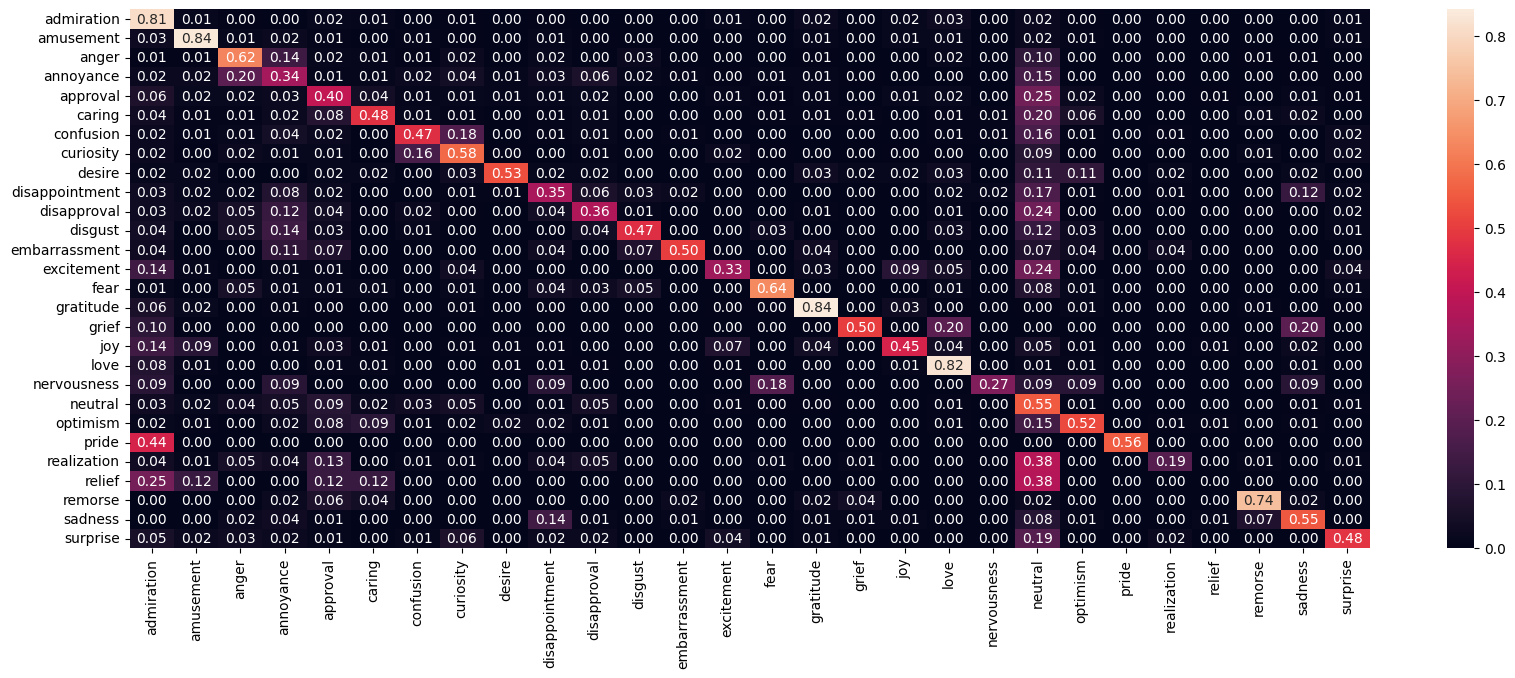

In [10]:
cm = val_confusion_matrix
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    pd.DataFrame(
        cm,
        columns=sorted(list(data_for_exp.goemotion.unique())),
        index=sorted(list(data_for_exp.goemotion.unique()))
    ),
    annot=True,
    fmt="1.2f"
)

### Misclassification Analysis 

In [11]:
PUNCUATION_LIST = list(string.punctuation)

In [12]:
c_dict = list(contractions.slang_dict) + list(contractions.contractions_dict)

In [13]:
for emotion in ["all"] + list(set(data_for_exp.goemotion.value_counts().index)):
    results = list()
    for n, df in [("correct", correct), ("misclassified", misclassification)]:
        if emotion != "all":
            df = df.loc[lambda f: f["goemotion"] == emotion]
            
        if df.shape[0] == 0:
            continue
        
        # compute values in the dataset
        df = df.assign(
            chars=lambda f: f["text"].apply(len),
            tokens=lambda f: f["text"].str.split().apply(len),
            emojis=lambda f: f.text.apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA])),
            stop_words=lambda f: f.text.str.split().apply(lambda x: len([t for t in x if t.lower() in STOP_WORDS])),
            high_case=lambda f: f.text.apply(lambda x: len([c for c in x if not c.islower()])),
            contractions=lambda f: f.text.str.split().apply(lambda x: len([t for t in x if t in c_dict])),
            ponctuation=lambda f: f.text.apply(lambda x: len([c for c in x if c in PUNCUATION_LIST])),
        )

        # compile statiscs
        char_length = df["chars"].mean()
        tokens = df["tokens"].mean()
        high_case_rate = df.high_case.sum() / df.chars.sum()
        emoji_rate = df.emojis.sum() / df.chars.sum()
        stop_words = df["stop_words"].sum() / df["tokens"].sum()
        contractions = df["contractions"].sum() / df["tokens"].sum()
        ponctuations = df["ponctuation"].sum() / df["chars"].sum()

        results.append({
            "type": n,
            "char_length": char_length,
            "token_length": tokens,
            "case_rate": high_case_rate,
            "ponctuations_rate": ponctuations,
            "emoji_rate": emoji_rate,
            "stop_words_rate": stop_words,
            "contraction_rate": contractions,
        })

    display(
        pd.DataFrame(results)
        .set_index(["type"]).T
        .assign(emotion=emotion)
        .reindex(columns=["emotion", "correct", "misclassified"])
        .assign(delta=lambda f: f["misclassified"] - f["correct"])
        .assign(rate=lambda f: f["misclassified"] / f["correct"])
    )

type,emotion,correct,misclassified,delta,rate
char_length,all,65.152432,74.603020,9.450587,1.145053
token_length,all,12.203337,14.007105,1.803768,1.147809
case_rate,all,0.267824,0.264437,-0.003387,0.987354
ponctuations_rate,all,0.040251,0.038897,-0.001354,0.966370
emoji_rate,all,0.000434,0.000821,0.000387,1.892331
stop_words_rate,all,0.436583,0.442556,0.005973,1.013682
contraction_rate,all,0.029246,0.031099,0.001853,1.063368


type,emotion,correct,misclassified,delta,rate
char_length,desire,51.696970,77.384615,25.687646,1.496889
token_length,desire,10.909091,15.641026,4.731935,1.433761
case_rate,desire,0.314771,0.287276,-0.027495,0.912651
ponctuations_rate,desire,0.041618,0.038767,-0.002850,0.931510
emoji_rate,desire,0.000586,0.000994,0.000408,1.695825
stop_words_rate,desire,0.450000,0.478689,0.028689,1.063752
contraction_rate,desire,0.033333,0.022951,-0.010383,0.688525


type,emotion,correct,misclassified,delta,rate
char_length,excitement,48.217391,56.218750,8.001359,1.165943
token_length,excitement,9.260870,10.234375,0.973505,1.105120
case_rate,excitement,0.325518,0.283213,-0.042306,0.870036
ponctuations_rate,excitement,0.057710,0.052807,-0.004903,0.915048
emoji_rate,excitement,0.000000,0.001112,0.001112,inf
stop_words_rate,excitement,0.370892,0.384733,0.013841,1.037318
contraction_rate,excitement,0.042254,0.029008,-0.013246,0.686514


type,emotion,correct,misclassified,delta,rate
char_length,fear,57.355556,77.972222,20.616667,1.359454
token_length,fear,10.755556,13.666667,2.911111,1.270661
case_rate,fear,0.255715,0.241539,-0.014176,0.944564
ponctuations_rate,fear,0.038357,0.037763,-0.000594,0.984501
emoji_rate,fear,0.000000,0.000000,0.000000,NaN
stop_words_rate,fear,0.454545,0.410569,-0.043976,0.903252
contraction_rate,fear,0.026860,0.026423,-0.000437,0.983740


type,emotion,correct,misclassified,delta,rate
char_length,embarrassment,62.833333,89.500000,26.666667,1.424403
token_length,embarrassment,11.416667,16.777778,5.361111,1.469586
case_rate,embarrassment,0.250663,0.243327,-0.007336,0.970734
ponctuations_rate,embarrassment,0.038462,0.033520,-0.004942,0.871508
emoji_rate,embarrassment,0.000000,0.000621,0.000621,inf
stop_words_rate,embarrassment,0.452555,0.460265,0.007710,1.017037
contraction_rate,embarrassment,0.014599,0.019868,0.005269,1.360927


type,emotion,correct,misclassified,delta,rate
char_length,grief,67.400000,66.714286,-0.685714,0.989826
token_length,grief,13.400000,12.571429,-0.828571,0.938166
case_rate,grief,0.222552,0.269807,0.047255,1.212334
ponctuations_rate,grief,0.014837,0.049251,0.034414,3.319486
emoji_rate,grief,0.000000,0.000000,0.000000,NaN
stop_words_rate,grief,0.492537,0.352273,-0.140265,0.715220
contraction_rate,grief,0.000000,0.034091,0.034091,inf


type,emotion,correct,misclassified,delta,rate
char_length,annoyance,75.336735,72.952663,-2.384072,0.968354
token_length,annoyance,13.795918,13.573964,-0.221954,0.983912
case_rate,annoyance,0.252743,0.253549,0.000806,1.003188
ponctuations_rate,annoyance,0.039144,0.038365,-0.000779,0.980095
emoji_rate,annoyance,0.000000,0.000568,0.000568,inf
stop_words_rate,annoyance,0.447485,0.451177,0.003692,1.008250
contraction_rate,annoyance,0.035503,0.037925,0.002422,1.068221


type,emotion,correct,misclassified,delta,rate
char_length,remorse,67.459459,89.454545,21.995086,1.326049
token_length,remorse,12.594595,16.681818,4.087224,1.324522
case_rate,remorse,0.279247,0.245427,-0.033820,0.878889
ponctuations_rate,remorse,0.052885,0.036077,-0.016807,0.682188
emoji_rate,remorse,0.000401,0.000508,0.000107,1.268293
stop_words_rate,remorse,0.401288,0.468665,0.067377,1.167903
contraction_rate,remorse,0.045064,0.049046,0.003982,1.088361


type,emotion,correct,misclassified,delta,rate
char_length,disapproval,69.935185,77.654971,7.719786,1.110385
token_length,disapproval,12.731481,14.421053,1.689571,1.132708
case_rate,disapproval,0.251026,0.263800,0.012774,1.050887
ponctuations_rate,disapproval,0.040646,0.033662,-0.006984,0.828177
emoji_rate,disapproval,0.000397,0.000452,0.000055,1.137586
stop_words_rate,disapproval,0.453818,0.454988,0.001170,1.002577
contraction_rate,disapproval,0.057455,0.038524,-0.018931,0.670511


type,emotion,correct,misclassified,delta,rate
char_length,sadness,64.600000,82.959184,18.359184,1.284198
token_length,sadness,12.680000,15.469388,2.789388,1.219983
case_rate,sadness,0.279670,0.267651,-0.012019,0.957024
ponctuations_rate,sadness,0.044995,0.043542,-0.001452,0.967721
emoji_rate,sadness,0.001445,0.000984,-0.000461,0.681075
stop_words_rate,sadness,0.456362,0.415567,-0.040794,0.910609
contraction_rate,sadness,0.030494,0.036939,0.006445,1.211355


type,emotion,correct,misclassified,delta,rate
char_length,joy,74.987500,67.135135,-7.852365,0.895284
token_length,joy,14.150000,12.972973,-1.177027,0.916818
case_rate,joy,0.265544,0.274960,0.009415,1.035457
ponctuations_rate,joy,0.039840,0.041868,0.002028,1.050903
emoji_rate,joy,0.000500,0.000604,0.000104,1.207528
stop_words_rate,joy,0.416961,0.456250,0.039289,1.094227
contraction_rate,joy,0.040636,0.020833,-0.019803,0.512681


type,emotion,correct,misclassified,delta,rate
char_length,pride,62.125000,71.333333,9.208333,1.148223
token_length,pride,12.250000,13.666667,1.416667,1.115646
case_rate,pride,0.249497,0.242991,-0.006506,0.973922
ponctuations_rate,pride,0.038229,0.035047,-0.003183,0.916749
emoji_rate,pride,0.000000,0.000000,0.000000,NaN
stop_words_rate,pride,0.520408,0.451220,-0.069189,0.867049
contraction_rate,pride,0.051020,0.060976,0.009955,1.195122


type,emotion,correct,misclassified,delta,rate
char_length,caring,65.746032,75.333333,9.587302,1.145823
token_length,caring,12.174603,14.461538,2.286935,1.187845
case_rate,caring,0.249879,0.255446,0.005567,1.022277
ponctuations_rate,caring,0.041043,0.034717,-0.006325,0.845882
emoji_rate,caring,0.000241,0.000340,0.000099,1.409803
stop_words_rate,caring,0.426336,0.452128,0.025791,1.060495
contraction_rate,caring,0.037810,0.030142,-0.007668,0.797200


type,emotion,correct,misclassified,delta,rate
char_length,neutral,64.759346,72.622222,7.862876,1.121417
token_length,neutral,12.043614,13.577778,1.534164,1.127384
case_rate,neutral,0.271771,0.267714,-0.004057,0.985073
ponctuations_rate,neutral,0.040769,0.039848,-0.000922,0.977397
emoji_rate,neutral,0.000325,0.001156,0.000831,3.560066
stop_words_rate,neutral,0.439731,0.432442,-0.007289,0.983425
contraction_rate,neutral,0.026449,0.034915,0.008467,1.320128


type,emotion,correct,misclassified,delta,rate
char_length,disgust,78.939394,79.875000,0.935606,1.011852
token_length,disgust,14.030303,14.660714,0.630411,1.044932
case_rate,disgust,0.246449,0.245026,-0.001423,0.994224
ponctuations_rate,disgust,0.035317,0.033982,-0.001335,0.962198
emoji_rate,disgust,0.000384,0.000447,0.000063,1.164766
stop_words_rate,disgust,0.434125,0.433618,-0.000508,0.998830
contraction_rate,disgust,0.021598,0.026797,0.005198,1.240682


type,emotion,correct,misclassified,delta,rate
char_length,amusement,62.187500,69.916667,7.729167,1.124288
token_length,amusement,11.687500,13.250000,1.562500,1.133690
case_rate,amusement,0.258137,0.278605,0.020469,1.079294
ponctuations_rate,amusement,0.036490,0.043206,0.006716,1.184051
emoji_rate,amusement,0.000696,0.003278,0.002582,4.710800
stop_words_rate,amusement,0.419992,0.416667,-0.003325,0.992083
contraction_rate,amusement,0.026738,0.037736,0.010998,1.411321


type,emotion,correct,misclassified,delta,rate
char_length,admiration,62.222571,71.358696,9.136125,1.146830
token_length,admiration,11.539185,13.413043,1.873859,1.162391
case_rate,admiration,0.256688,0.257121,0.000433,1.001687
ponctuations_rate,admiration,0.038239,0.036253,-0.001986,0.948067
emoji_rate,admiration,0.000252,0.000457,0.000205,1.814075
stop_words_rate,admiration,0.409943,0.429498,0.019555,1.047701
contraction_rate,admiration,0.022005,0.025932,0.003927,1.178462


type,emotion,correct,misclassified,delta,rate
char_length,optimism,78.086022,80.166667,2.080645,1.026646
token_length,optimism,14.827957,15.095238,0.267281,1.018025
case_rate,optimism,0.257367,0.259281,0.001914,1.007437
ponctuations_rate,optimism,0.034839,0.036086,0.001247,1.035783
emoji_rate,optimism,0.000000,0.000891,0.000891,inf
stop_words_rate,optimism,0.446701,0.446372,-0.000328,0.999265
contraction_rate,optimism,0.027556,0.032334,0.004778,1.173398


type,emotion,correct,misclassified,delta,rate
char_length,curiosity,63.493333,75.486842,11.993509,1.188894
token_length,curiosity,11.973333,14.184211,2.210877,1.184650
case_rate,curiosity,0.272680,0.262158,-0.010522,0.961414
ponctuations_rate,curiosity,0.044099,0.042182,-0.001917,0.956534
emoji_rate,curiosity,0.000105,0.000349,0.000244,3.320202
stop_words_rate,curiosity,0.478842,0.459184,-0.019658,0.958946
contraction_rate,curiosity,0.027840,0.030612,0.002773,1.099592


type,emotion,correct,misclassified,delta,rate
char_length,disappointment,79.550000,75.827273,-3.722727,0.953203
token_length,disappointment,14.575000,14.572727,-0.002273,0.999844
case_rate,disappointment,0.257700,0.260281,0.002581,1.010015
ponctuations_rate,disappointment,0.037398,0.036686,-0.000712,0.980972
emoji_rate,disappointment,0.000000,0.000240,0.000240,inf
stop_words_rate,disappointment,0.440823,0.446663,0.005839,1.013246
contraction_rate,disappointment,0.042882,0.034311,-0.008571,0.800125


type,emotion,correct,misclassified,delta,rate
char_length,approval,67.474074,74.604167,7.130093,1.105672
token_length,approval,12.548148,13.962500,1.414352,1.112714
case_rate,approval,0.253156,0.264731,0.011574,1.045720
ponctuations_rate,approval,0.037655,0.038593,0.000938,1.024897
emoji_rate,approval,0.000329,0.001396,0.001067,4.239505
stop_words_rate,approval,0.434475,0.443748,0.009274,1.021344
contraction_rate,approval,0.025974,0.027156,0.001182,1.045509


type,emotion,correct,misclassified,delta,rate
char_length,nervousness,95.714286,70.538462,-25.175824,0.736969
token_length,nervousness,16.571429,13.615385,-2.956044,0.821618
case_rate,nervousness,0.229851,0.262814,0.032963,1.143409
ponctuations_rate,nervousness,0.028358,0.044711,0.016353,1.576652
emoji_rate,nervousness,0.000000,0.000000,0.000000,NaN
stop_words_rate,nervousness,0.456897,0.446328,-0.010569,0.976868
contraction_rate,nervousness,0.077586,0.039548,-0.038038,0.509730


type,emotion,correct,misclassified,delta,rate
char_length,relief,77.500000,69.357143,-8.142857,0.894931
token_length,relief,16.000000,12.571429,-3.428571,0.785714
case_rate,relief,0.258065,0.296601,0.038537,1.149331
ponctuations_rate,relief,0.032258,0.045314,0.013056,1.404737
emoji_rate,relief,0.000000,0.000000,0.000000,NaN
stop_words_rate,relief,0.406250,0.392045,-0.014205,0.965035
contraction_rate,relief,0.031250,0.039773,0.008523,1.272727


type,emotion,correct,misclassified,delta,rate
char_length,gratitude,57.424812,71.594595,14.169783,1.246754
token_length,gratitude,10.725564,13.675676,2.950112,1.275054
case_rate,gratitude,0.270769,0.267648,-0.003121,0.988473
ponctuations_rate,gratitude,0.044714,0.039638,-0.005076,0.886478
emoji_rate,gratitude,0.000262,0.000378,0.000116,1.441582
stop_words_rate,gratitude,0.417455,0.403162,-0.014293,0.965761
contraction_rate,gratitude,0.026288,0.023715,-0.002573,0.902134


type,emotion,correct,misclassified,delta,rate
char_length,confusion,75.833333,81.084337,5.251004,1.069244
token_length,confusion,14.833333,15.433735,0.600402,1.040477
case_rate,confusion,0.280098,0.270877,-0.009221,0.967079
ponctuations_rate,confusion,0.035409,0.043685,0.008276,1.233724
emoji_rate,confusion,0.000000,0.000000,0.000000,NaN
stop_words_rate,confusion,0.495630,0.477752,-0.017879,0.963927
contraction_rate,confusion,0.054931,0.021858,-0.033073,0.397914


type,emotion,correct,misclassified,delta,rate
char_length,surprise,78.646154,67.557692,-11.088462,0.859008
token_length,surprise,14.600000,12.807692,-1.792308,0.877239
case_rate,surprise,0.270931,0.287219,0.016288,1.060118
ponctuations_rate,surprise,0.039124,0.047538,0.008414,1.215064
emoji_rate,surprise,0.000587,0.000569,-0.000018,0.970111
stop_words_rate,surprise,0.430980,0.432432,0.001452,1.003370
contraction_rate,surprise,0.050580,0.034535,-0.016045,0.682777


type,emotion,correct,misclassified,delta,rate
char_length,realization,79.750000,85.130000,5.380000,1.067461
token_length,realization,14.600000,15.980000,1.380000,1.094521
case_rate,realization,0.255172,0.263832,0.008659,1.033935
ponctuations_rate,realization,0.040752,0.035945,-0.004807,0.882036
emoji_rate,realization,0.000000,0.000705,0.000705,inf
stop_words_rate,realization,0.496575,0.461202,-0.035374,0.928764
contraction_rate,realization,0.017123,0.027534,0.010411,1.608010


type,emotion,correct,misclassified,delta,rate
char_length,love,62.191257,72.459459,10.268203,1.165107
token_length,love,12.273224,14.054054,1.780830,1.145099
case_rate,love,0.282576,0.274897,-0.007679,0.972826
ponctuations_rate,love,0.038485,0.041029,0.002544,1.066110
emoji_rate,love,0.002460,0.004476,0.002016,1.819310
stop_words_rate,love,0.426981,0.430769,0.003788,1.008871
contraction_rate,love,0.019590,0.017308,-0.002283,0.883479


type,emotion,correct,misclassified,delta,rate
char_length,anger,56.411111,70.763889,14.352778,1.254432
token_length,anger,10.766667,12.888889,2.122222,1.197110
case_rate,anger,0.307662,0.268302,-0.039360,0.872068
ponctuations_rate,anger,0.044908,0.038077,-0.006832,0.847871
emoji_rate,anger,0.000591,0.000196,-0.000395,0.332156
stop_words_rate,anger,0.429309,0.440733,0.011424,1.026611
contraction_rate,anger,0.021672,0.020474,-0.001198,0.944735


### Phrase Example 

In [14]:
for e, p in val_metrics["misclassification_examples"].items():
    print("=" * 125)
    print(e)
    print("=" * 125)
    for v in p:
        print(v)
        print()

admiration
This gives me life

[NAME] gives me the weirdest boner. I love these guys

This really comforted me. Like genuinely. Thank you so much. You seem like a truly amazing person.

amusement
Oh dear, you are entertaining. Please, talk more to me. 

Lmao seriously this is stupid. HEY GUYS DO YOU GUYS AS INTJS NEED TO DRINK WATER? NOT ME

anger
beating up tire man

That's probably the price a [NAME] pays to rent the Trump Hotel D.C. Ballroom for a cocktail party. Whoop de fucking doo.

Damnit, now they're ruining IKEA too.

annoyance
[NAME] fuck those creeps

Also his weird spiked haircut. I wanted spiked hair when I was like 6. I also wanted a mohawk. I'm not 6 anymore.

I REALLY hate this one

approval
Yeah google it I def want it!!

Why does everyone hate the creme brûlées? They’re easily my favorite.

You will not have damage to extremities when applied in a temporary situation as in this case. Simple as that.

caring
I would post on r/legaladvice to see if there is some way you

---